In [1]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import torch

import numpy as np
import pandas as pd

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
from packages.custom_utils import PortfolioOptimizationEnv, custom_reward_function, sharpe_ratio_reward_function
from packages.models import DRLAgent
from packages.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Load the data
df_portfolio_train = pd.read_parquet('datasets/df_portfolio_train.parquet')
# df_portfolio_2021 = pd.read_parquet('datasets/df_portfolio_2021.parquet')
# df_portfolio_2022 = pd.read_parquet('datasets/df_portfolio_2022.parquet')
# df_portfolio_2023 = pd.read_parquet('datasets/df_portfolio_2023.parquet')
df_portfolio_test = pd.read_parquet('datasets/df_portfolio_test.parquet')

TEST_SET = [
    "AAPL", "CVX", "GS", "JNJ",
    "JPM", "MSFT", "PFE", "PG",
    "GOOG", "XOM"
]
START_DATE = '2014-01-01'
END_DATE = '2024-12-31'
print(len(TEST_SET))

df_portfolio_vali = df_portfolio_train[df_portfolio_train["date"] >= "2021-01-01"]
df_portfolio_train = df_portfolio_train[df_portfolio_train["date"] < "2021-01-01"]

10


In [2]:
FEATURE_NAMES = ["close",
               "vmd_mode_0",
                "vmd_mode_1",
                "vmd_mode_2",
                  #"high", 
                  #"low",
                'High_VIX',
                'Low_VIX',
                  #'Close_VIX',
                'High_SPY',
                'Low_SPY',
                'Close_SPY',
                  #'Volume_SPY',
                'Fear Greed', 
                'ratingScore',
                  #'ratingDetailsDCFScore',
                'ratingDetailsROEScore',
                  #'ratingDetailsROAScore',
                  #'ratingDetailsPEScore',
                  #'ratingDetailsPBScore',
                  #'expenses',
                  #'GDP', 
                'exports', 
                  #'imports',
                'pound_dollar_exchange_rate', 
                'unemployment',
                'ics',
                'TTM Revenue(Billion)',
                  #'TTM EBITDA(Billion)',
                  #'EBITDA Margin',
                'Price to Book Ratio',
                  #'PE Ratio',
                'Price to Sales Ratio',
                  #'Assets',
                  #'NetIncomeLoss',
                'Return on Equity(%)']

TIME_WINDOW = 90
COMISSION_FEE = 0.001
K_SIZE = 5  
CONV_MID = 10
CONV_FINAL= 20
LEARNING_RATE = 0.02
print(len(FEATURE_NAMES))

20


In [3]:
train_env = PortfolioOptimizationEnv(
    df_portfolio_train,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None,
    reward_function=custom_reward_function,
    reward_scaling=1.0
)   

# Create validation environment
vali_env = PortfolioOptimizationEnv(
    df_portfolio_vali,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None,
    reward_function=custom_reward_function,
    reward_scaling=1.0,

)

# Create test environment
test_env = PortfolioOptimizationEnv(
    df_portfolio_test,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None,
    reward_function=custom_reward_function,
    reward_scaling=1.0
)

test_env.reset()
train_env.reset()
vali_env.reset()

model_kwargs = {
    "lr": LEARNING_RATE,
    "policy": EIIE,
    "validation_env": vali_env,
}

policy_kwargs = {
    "initial_features": len(FEATURE_NAMES),
    "k_size": K_SIZE,
    "time_window": TIME_WINDOW,
    "conv_mid_features": CONV_MID,
    "conv_final_features": CONV_FINAL,
    "device": device 
}

agent = DRLAgent(train_env)
EIIE_model = agent.get_model("pg", device, model_kwargs, policy_kwargs)

In [ ]:
# #for training purposes only 
# agent.train_model(
#     EIIE_model,
#     episodes=100,
#     validation_freq=3,
#     patience=10,
#     threshold = 0.01
# )

# torch.save(EIIE_model.train_policy.state_dict(), "policy_EIIE_90_5_10_20_0.02.pt")

In [ ]:
EIIE_results = {
    "train": {},
    "validation": {},
    "test": {} }

EIIE_policy = EIIE(time_window=TIME_WINDOW, device=device, initial_features=len(FEATURE_NAMES),
                   k_size=K_SIZE, conv_mid_features=CONV_MID, conv_final_features=CONV_FINAL)

EIIE_policy.load_state_dict(torch.load("finalmodel.pt"))


C:\Users\xutia\AppData\Local\Temp\ipykernel_27600\762576401.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  EIIE_policy.load_state_dict(torch.load("policy_EIIE_90_5_10_2

<All keys matched successfully>

In [14]:
import os 
import shutil
# Function to calculate the final accumulative portfolio value
def calculate_cumulative_value(portfolio_values):
    initial_value = portfolio_values[0]
    final_value = portfolio_values[-1]
    return final_value / initial_value

# Function to calculate the maximum drawdown
def calculate_max_drawdown(portfolio_values):
    portfolio_values = np.array(portfolio_values)
    running_max = np.maximum.accumulate(portfolio_values)
    drawdowns = (portfolio_values - running_max) / running_max
    max_drawdown = drawdowns.min()
    
    return max_drawdown

# Function to calculate the Sharpe ratio
def calculate_sharpe_ratio(portfolio_values, risk_free_rate=0):
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    excess_returns = returns - risk_free_rate
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)
    sharpe_ratio_annualized = sharpe_ratio * np.sqrt(252)
    
    return sharpe_ratio_annualized


# Define a function to calculate the metrics (this is just a placeholder; replace with actual functions)
def calculate_metrics(environment):
    final_portfolio_value = environment._asset_memory["final"][-1]
    max_drawdown = calculate_max_drawdown(environment._asset_memory["final"])
    sharpe_ratio = calculate_sharpe_ratio(environment._asset_memory["final"])
    cumulative_value = calculate_cumulative_value(environment._asset_memory["final"])
    return final_portfolio_value, max_drawdown, sharpe_ratio, cumulative_value

# DataFrame to store results
columns = ["TIME_WINDOW", "K_SIZE", "CONV_MID", "CONV_FINAL", 
        'train_portfolio_value', 'train_drawdown', 'train_sharpe', 'train_cumulative',
          'test_portfolio_value', 'test_drawdown', 'test_sharpe', 'test_cumulative']

results_df = pd.DataFrame(columns=columns)


In [15]:
train_env.reset()
src_folder = "results/rl"
dst_folder = "results/train"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, train_env, policy=None, learning_rate=0, optimizer = None)
os.rename(src_folder, dst_folder)
EIIE_results["train"]["value"] = train_env._asset_memory["final"]
EIIE_results["train"]["actions"] = train_env._actions_memory
train_final_value, train_drawdown, train_sharpe, train_cumulative = calculate_metrics(train_env)

vali_env.reset()
src_folder = "results/rl"
dst_folder = "results/validation"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, vali_env, policy=EIIE_policy, learning_rate=0.02)
os.rename(src_folder, dst_folder)
EIIE_results["validation"]["value"] = vali_env._asset_memory["final"]
EIIE_results["validation"]["actions"] = vali_env._actions_memory
vali_final_value, vali_drawdown, vali_sharpe, vali_cumulative = calculate_metrics(vali_env)


test_env.reset()
src_folder = "results/rl"
dst_folder = "results/test"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, test_env, policy=EIIE_policy, learning_rate=0.02)
os.rename(src_folder, dst_folder)
EIIE_results["test"]["value"] = test_env._asset_memory["final"]
EIIE_results["test"]["actions"] = test_env._actions_memory
portfolio_test_value, drawdown_test, sharpe_test, cumulative_test = calculate_metrics(test_env)


# EI3_policy = EI3(time_window=50, device=device)
# EI3_policy.load_state_dict(torch.load("policy_EI3.pt"))

# environment.reset()
# DRLAgent.DRL_validation(EI3_model, environment, policy=EI3_policy)
# EI3_results["train"]["value"] = environment._asset_memory["final"]
# environment_2021.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2021, policy=EI3_policy)
# EI3_results["2021"]["value"] = environment_2021._asset_memory["final"]
# environment_2022.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2022, policy=EI3_policy)
# EI3_results["2022"]["value"] = environment_2022._asset_memory["final"]
# environment_2023.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2023, policy=EI3_policy)
# EI3_results["2023"]["value"] = environment_2023._asset_memory["final"]

new_row = pd.DataFrame([{

    "TIME_WINDOW": TIME_WINDOW, 
    "K_SIZE": K_SIZE, 
    "CONV_MID": CONV_MID, 
    "CONV_FINAL": CONV_FINAL,
    'train_portfolio_value': train_final_value, 
    'train_drawdown': train_drawdown, 
    'train_sharpe': train_sharpe, 
    'train_cumulative': train_cumulative,
    'validation_portfolio_value': vali_final_value, 
    'validation_drawdown': vali_drawdown, 
    'validation_sharpe': vali_sharpe, 
    'validation_cumulative': vali_cumulative,
    'test_portfolio_value': portfolio_test_value, 
    'test_drawdown': drawdown_test, 
    'test_sharpe': sharpe_test, 
    'test_cumulative': cumulative_test
}])
results_df = pd.concat([results_df, new_row], ignore_index=True)


#uniform buy n hold
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
UBAH_results = {
    "train": {"value": [], "actions": []},
    "validation": {"value": [], "actions": []},
    "test": {"value": [], "actions": []}
}


PORTFOLIO_SIZE = len(TEST_SET)

# Train period
terminated = False
train_env.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = train_env.step(action)
    UBAH_results["train"]["actions"].append(action)
UBAH_results["train"]["value"] = train_env._asset_memory["final"]

# Validation period
terminated = False
vali_env.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = vali_env.step(action)
    UBAH_results["validation"]["actions"].append(action)
UBAH_results["validation"]["value"] = vali_env._asset_memory["final"]

# Test period
terminated = False
test_env.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = test_env.step(action)
    UBAH_results["test"]["actions"].append(action)
UBAH_results["test"]["value"] = test_env._asset_memory["final"]

metrics_df = pd.DataFrame({
    "date": test_env._date_memory,
    "returns": test_env._portfolio_return_memory,
    "rewards": test_env._portfolio_reward_memory,
    "portfolio_values": test_env._asset_memory["final"],
})
# metrics_df.to_csv("metrics_df.csv")

Initial portfolio value: 100000
Final portfolio value: 1673852.75
Final accumulative portfolio return: 16.7385275
Maximum DrawDown: -0.2705773036758541
Sharpe ratio: 1.6539417126974112
Initial portfolio value: 100000
Final portfolio value: 190805.65625
Final accumulative portfolio return: 1.9080565625
Maximum DrawDown: -0.18485337312223482
Sharpe ratio: 1.4766382076444795
Initial portfolio value: 100000
Final portfolio value: 154338.328125
Final accumulative portfolio return: 1.54338328125
Maximum DrawDown: -0.14013357932046233
Sharpe ratio: 1.5790382285372775


C:\Users\xutia\AppData\Local\Temp\ipykernel_27600\217973807.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


Initial portfolio value: 100000
Final portfolio value: 238149.5625
Final accumulative portfolio return: 2.381495625
Maximum DrawDown: -0.3526257544940411
Sharpe ratio: 0.777208103271643
Initial portfolio value: 100000
Final portfolio value: 120635.78125
Final accumulative portfolio return: 1.2063578125
Maximum DrawDown: -0.15936417275989456
Sharpe ratio: 0.7247539370823404
Initial portfolio value: 100000
Final portfolio value: 128299.1875
Final accumulative portfolio return: 1.282991875
Maximum DrawDown: -0.09892252728646544
Sharpe ratio: 1.7361002784954376


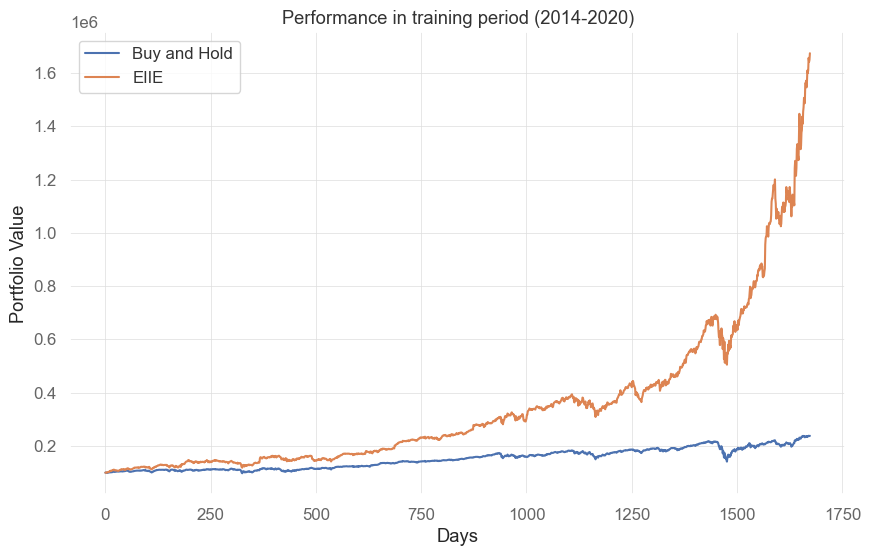

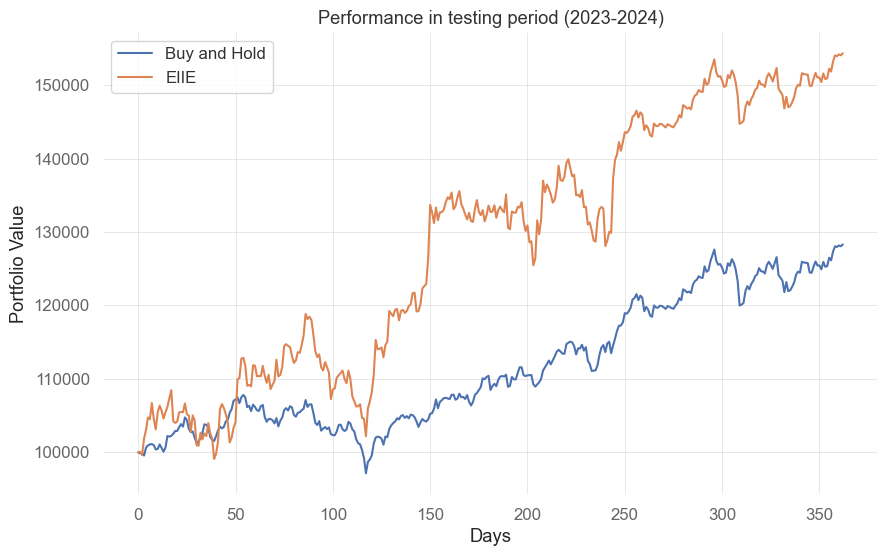

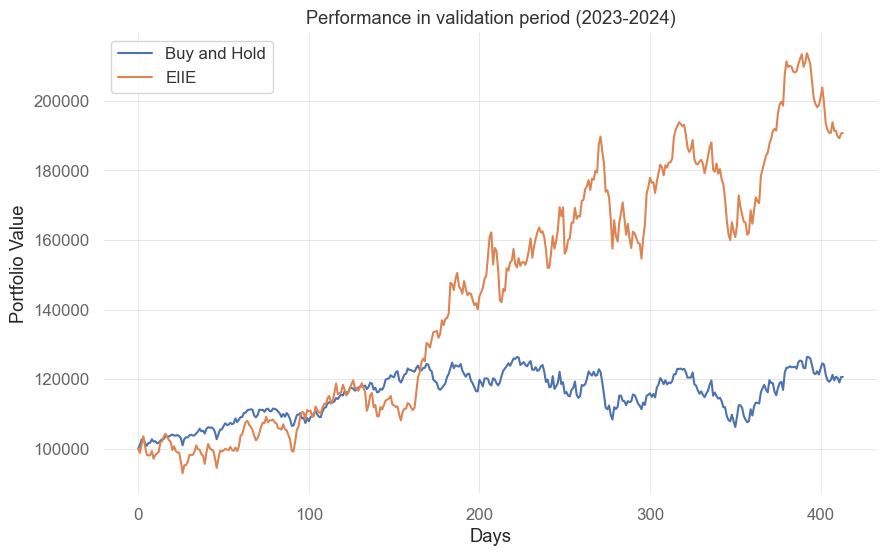

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["train"]["value"], label="EIIE")
#plt.plot(EI3_results["train"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period (2014-2020)")
plt.legend()

plt.show()

plt.plot(UBAH_results["test"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["test"]["value"], label="EIIE")
#plt.plot(EI3_results["2023"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in testing period (2023-2024)")
plt.legend()

plt.show()

plt.plot(UBAH_results["validation"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["validation"]["value"], label="EIIE")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in validation period (2023-2024)")
plt.legend()

plt.show()

In [11]:
# # Create DataFrame for train UBAH results
# UBAH_train_df = pd.DataFrame({
#     "portfolio_value": UBAH_results["train"]["value"],
#     "step": range(len(UBAH_results["train"]["value"])),
#     "type": "train"
# })

# # Create DataFrame for test UBAH results
# UBAH_test_df = pd.DataFrame({
#     "portfolio_value": UBAH_results["test"]["value"],
#     "step": range(len(UBAH_results["test"]["value"])),
#     "type": "test"
# })

# # Combine the DataFrames
# UBAH_results_df = pd.concat([UBAH_train_df, UBAH_test_df], ignore_index=True)

# # Save to CSV
# UBAH_results_df.to_csv("newresults/UBAH_baseline.csv", index=False)


C:\Users\xutia\AppData\Local\Temp\ipykernel_27600\1587967407.py:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax1.plot(df['row_number'], df["cumulative_change"], "b", label='Train Cumulative Change', color = train_color_cum)
C:\Users\xutia\AppData\Local\Temp\ipykernel_27600\1587967407.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  ax2.plot(df['row_number'], df["max_drawdown"], "r", label='Train Max Drawdown', color = train_color_dd)


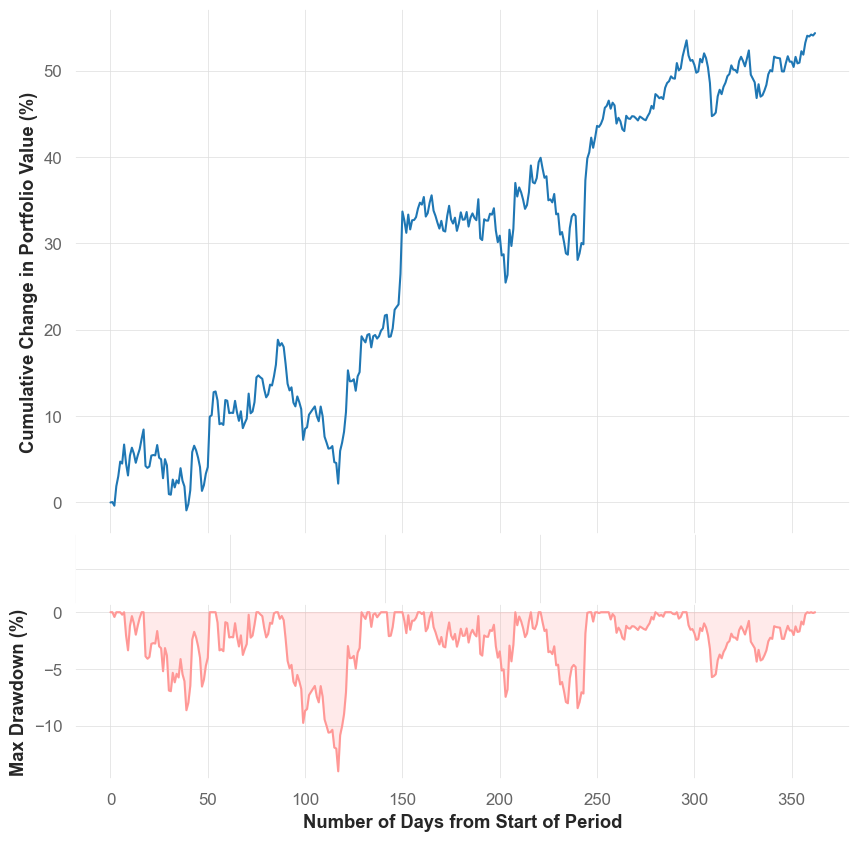

In [33]:

import matplotlib.pyplot as plt
import quantstats as qs
import matplotlib.gridspec as gridspec

metrics_val = pd.read_csv(r"results/validation/metrics_data.csv")
metrics_train = pd.read_csv(r"results/train/metrics_data.csv")
metrics_test = pd.read_csv(r"results/test/metrics_data.csv")

def transform_df(df):
    df.reset_index(drop=False, inplace=True)  
    df.rename(columns={'index': 'row_number'}, inplace=True)

    def calculate_rowwise_max_drawdown(portfolio_values):
        portfolio_values = np.array(portfolio_values)
        max_drawdowns = np.zeros(len(portfolio_values))  # Array to hold max drawdowns for each time step
        running_max = -np.inf  # Initialize running max to negative infinity
        for i in range(len(portfolio_values)):
            # Update the running maximum
            running_max = max(running_max, portfolio_values[i])
            # Calculate drawdown for the current value
            drawdown = (portfolio_values[i] - running_max) / running_max
            # Store the maximum drawdown observed up to this point
            max_drawdowns[i] = drawdown if drawdown < 0 else 0  # Only store negative drawdowns
        return max_drawdowns

    df['max_drawdown'] = calculate_rowwise_max_drawdown(df['portfolio_values'])*100
    df['cumulative_change'] = ((df['portfolio_values'] - df['portfolio_values'][0])/df['portfolio_values'][0])*100
    return df

metrics_val_plot = transform_df(metrics_val)
metrics_train_plot = transform_df(metrics_train)
metrics_test_plot = transform_df(metrics_test)

def qs_plotter(df):
    train_color_cum =  "#1f77b4" 
    train_color_dd =   "#ff9896"  
    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    for ax in axs:
        ax.tick_params(axis='both', which='both', labelbottom=False, labelleft=False)
    df['date'] = pd.to_datetime(df['date'])
    df['date'] = df['date'].dt.strftime("%d %b %Y")
    earliest_date = df['date'][0]
    latest_date = df['date'][len(df)-1]
    ax1 = fig.add_subplot(gs[0])  # Larger subplot
    ax1.plot(df['row_number'], df["cumulative_change"], "b", label='Train Cumulative Change', color = train_color_cum)
    ax1.tick_params(axis='x', which='both', labelbottom=False, labelleft=False)
    ax1.set_ylabel("Cumulative Change in Portfolio Value (%)", fontweight='bold')
    # ax1.legend(loc="lower right")  # Move legend to the right



    ax2 = fig.add_subplot(gs[1])  # Smaller subplot
    ax2.plot(df['row_number'], df["max_drawdown"], "r", label='Train Max Drawdown', color = train_color_dd)
    ax2.fill_between(df['row_number'], df["max_drawdown"], 0, 
                    color= train_color_dd, alpha=0.2)
    ax2.set_ylabel("Max Drawdown (%)", fontweight='bold')
    # ax2.tick_params(axis='x', which='both', labelbottom=False, labelleft=False)
    ax2.set_xlabel("Number of Days from Start of Period", fontweight='bold')
    # ax3 = fig.add_subplot(gs[2])  # Smaller subplot
    # ax3.plot(df['row_number'], df["returns"]*100, "b")
    # ax3.set_ylabel("Daily Return (%)", fontweight='bold')
    # ax3.set_xlabel("Number of Days from Start of Period", fontweight='bold')
    # ax3.fill_between(df['row_number'], df["returns"] * 100, 0, 
    #                  where=(df["returns"] * 100 > 0), color='green', alpha=0.3)
    # ax3.fill_between(df['row_number'], df["returns"] * 100, 0, 
    #                  where=(df["returns"] * 100 < 0), color='red', alpha=0.3)
    # ax2.legend(loc="lower right") # Adding legend for cumulative change
    # plt.tight_layout()
    # ax1.set_title(f"Portfolio Statistics from {earliest_date} to {latest_date}", fontweight='bold')
    plt.close()
    return fig

plottrain = qs_plotter(metrics_test_plot)
plottrain


In [37]:
metrics_test_plot["cumulative_change"], metrics_val_plot["cumulative_change"], metrics_train_plot["cumulative_change"]

(0       0.000000
 1       0.049156
 2      -0.367711
 3       1.884508
 4       3.023625
          ...    
 358    54.035312
 359    53.946125
 360    54.170297
 361    54.060781
 362    54.338328
 Name: cumulative_change, Length: 363, dtype: float64,
 0       0.000000
 1      -1.232398
 2       1.215977
 3       3.580867
 4       0.649695
          ...    
 409    91.422031
 410    89.733531
 411    89.280938
 412    90.634125
 413    90.805656
 Name: cumulative_change, Length: 414, dtype: float64,
 0          0.000000
 1          0.152484
 2          0.160102
 3         -0.703359
 4          0.733719
            ...     
 1669    1510.208625
 1670    1556.522125
 1671    1542.088500
 1672    1548.898875
 1673    1573.852750
 Name: cumulative_change, Length: 1674, dtype: float64)

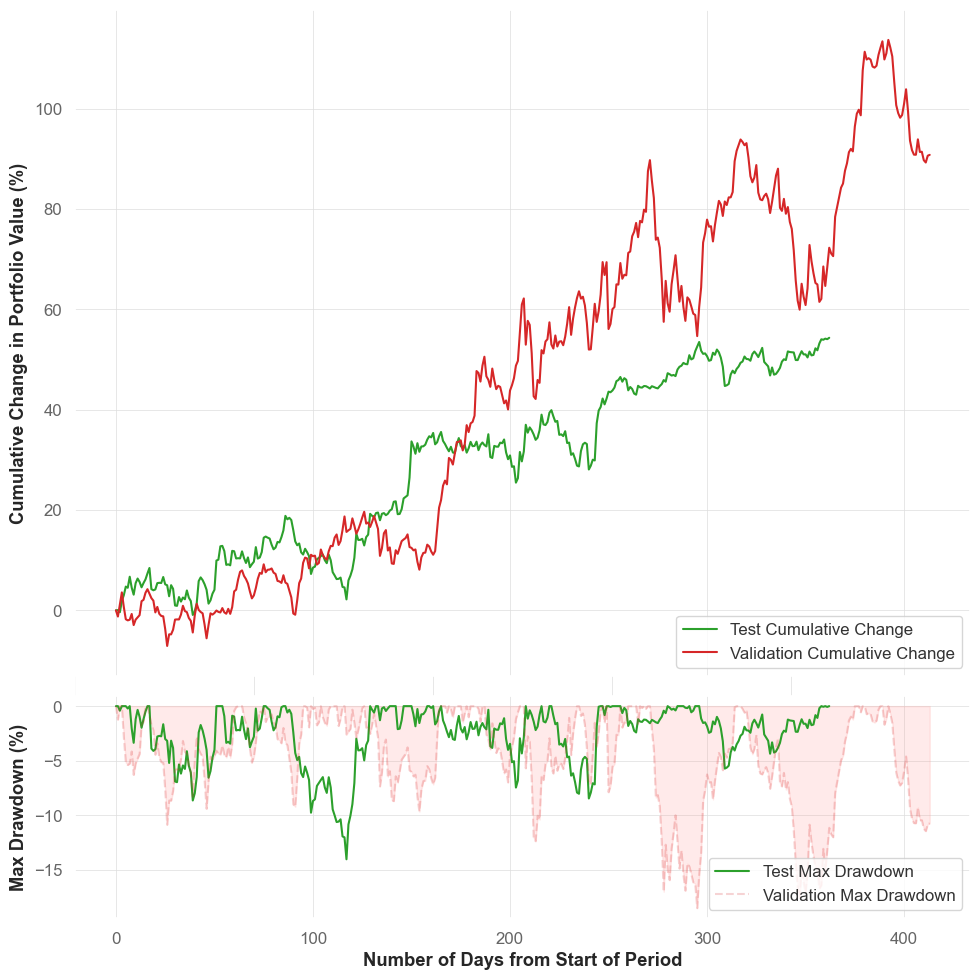

In [42]:
def qs_twoplots(df1, df2):
    rl_color_cum = "#2ca02c"
    train_color_cum = "#1f77b4"
    test_color_cum = "#d62728"

    rl_color_dd = "#98df8a"
    train_color_dd = "#aec7e8"
    test_color_dd = "#ff9896"

    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    for ax in axs:
        ax.tick_params(axis='both', which='both', labelbottom=False, labelleft=False)

    # Convert dates to datetime format with specific format if they are not already
    for df in [df1, df2]:
        df['date'] = pd.to_datetime(df['date'], format="%d %b %Y", errors='coerce')

    # Find the earliest and latest dates for the plot
    earliest_date = min(df1['date'].min(), df2['date'].min())
    latest_date = max(df1['date'].max(), df2['date'].max())

    ax1 = fig.add_subplot(gs[0])  # Larger subplot
    ax1.plot(df1['row_number'], df1["cumulative_change"], label='Test Cumulative Change', color=rl_color_cum)
    ax1.plot(df2['row_number'], df2["cumulative_change"], label='Validation Cumulative Change', color=test_color_cum)

    ax1.tick_params(axis='x', which='both', labelbottom=False, labelleft=False)
    ax1.set_ylabel("Cumulative Change in Portfolio Value (%)", fontweight='bold')
    ax1.legend(loc="lower right")

    ax2 = fig.add_subplot(gs[1])  # Smaller subplot
    ax2.plot(df1['row_number'], df1["max_drawdown"], label='Test Max Drawdown', color=rl_color_cum, linestyle='-')
    ax2.plot(df2['row_number'], df2["max_drawdown"], label='Validation Max Drawdown', color=test_color_cum, linestyle='--', alpha=0.2)
    ax2.fill_between(df2['row_number'], df2["max_drawdown"], 0, color=test_color_dd, alpha=0.2)

    ax2.legend(loc="lower right")
    ax2.set_ylabel("Max Drawdown (%)", fontweight='bold')
    ax2.set_xlabel("Number of Days from Start of Period", fontweight='bold')

    plt.tight_layout()
    plt.close()
    return fig

plot1 = qs_twoplots(metrics_test_plot, metrics_val_plot)
plot1


In [27]:
metrics_val_plot

,row_number,date,returns,rewards,portfolio_values,max_drawdown,cumulative_change
0,0,2021-05-12,0.000000,0.000000,100000.000000,0.000000,0.000000
1,1,2021-05-13,-0.012324,-60.934188,98767.601562,-1.232398,-1.232398
2,2,2021-05-14,0.024789,-99.251007,101215.976562,0.000000,1.215977
3,3,2021-05-17,0.023365,-177.086354,103580.867188,0.000000,3.580867
4,4,2021-05-18,-0.028298,-158.636974,100649.695312,-2.829839,0.649695
...,...,...,...,...,...,...,...
409,409,2022-12-23,0.000221,-3511.894136,191422.031250,-10.434160,91.422031
410,410,2022-12-27,-0.008821,-3514.771329,189733.531250,-11.224204,89.733531
411,411,2022-12-28,-0.002385,-3517.449317,189280.937500,-11.435972,89.280938
412,412,2022-12-29,0.007149,-3520.499496,190634.125000,-10.802819,90.634125


In [18]:
metrics_train_plot["cumulative_change"].max()
# metrics_test_plot

123.63296875

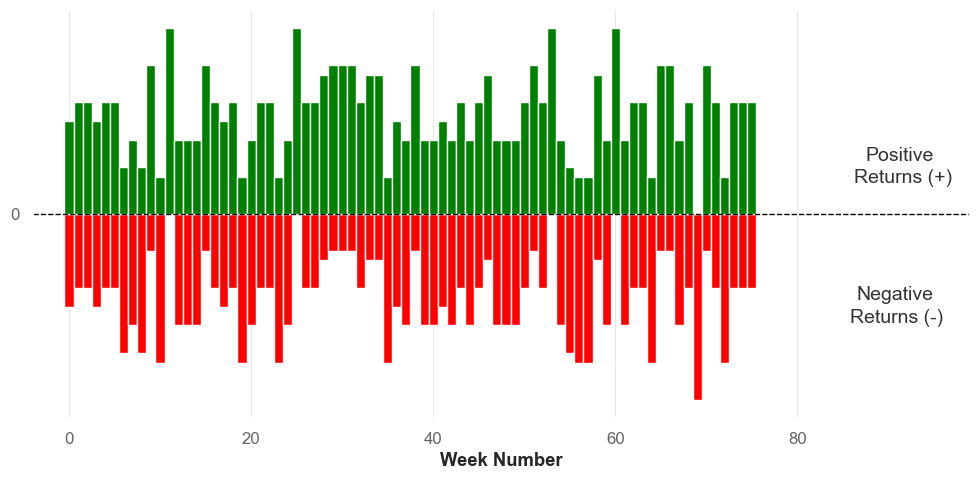

In [43]:
metrics_test_plot['date'] = pd.to_datetime(metrics_test_plot['date'])
metrics_rl_plot_monthly = (
    metrics_test_plot.groupby(pd.Grouper(key='date', freq='W'))
    .agg(positive_returns=('returns', lambda x: (x > 0).sum()),  # Count positive returns
         total_days =('returns', 'size'))  # Count total weeks
    .reset_index()
)
# Calculate the proportion of positive returns
metrics_rl_plot_monthly['proportion_positive'] = metrics_rl_plot_monthly['positive_returns'] / metrics_rl_plot_monthly['total_days']

# Rename columns for clarity
metrics_rl_plot_monthly.rename(columns={'date': 'month', 'proportion_positive': 'proportion_of_positive_returns'}, inplace=True)
metrics_rl_plot_monthly['month'] = metrics_rl_plot_monthly['month'].dt.strftime("%b %Y")
metrics_rl_plot_monthly['row_number'] = range(len(metrics_rl_plot_monthly))
metrics_rl_plot_monthly['proportion_of_positive_returns'] = metrics_rl_plot_monthly['proportion_of_positive_returns'] * 100
metrics_rl_plot_monthly['red'] = 100 - metrics_rl_plot_monthly['proportion_of_positive_returns']
metrics_rl_plot_monthly['green'] = metrics_rl_plot_monthly['proportion_of_positive_returns']
# plt.plot(metrics_rl_plot_monthly['row_number'], metrics_rl_plot_monthly["proportion_of_positive_returns"]*100, "b")
fig, ax = plt.subplots(figsize=(10, 5))
# metrics_rl_plot_monthly
# Plotting stacked bars
row_number = metrics_rl_plot_monthly['row_number']
bar_width=1
# Plot the red portion (below 50%)
ax.bar(row_number, -metrics_rl_plot_monthly['red'], 
       bar_width, label='Negative Return', color='red')

# Plot the green portion (above 50%)
ax.bar(row_number, metrics_rl_plot_monthly['green'], 
       bar_width, label='Positive Return', color='green')

# Add a reference line at y=0 (which corresponds to the 50% mark)
ax.axhline(0, color='black', linewidth=1, linestyle='--')

# Set axis labels and title
ax.set_xlabel("Week Number", fontweight='bold')
# ax.set_title("Win Rate of Portfolio by Week", fontweight='bold')
ax.set_yticks([0])  # Only show tick at 0
ax.set_yticklabels([0])  # Set the label for the tick

plt.annotate('Positive', (95, 25), textcoords="offset points", xytext=(0,5), ha='right', fontsize=14)
plt.annotate('Negative', (95, -50), textcoords="offset points", xytext=(0,5), ha='right', fontsize=14)
plt.annotate('Returns (+)', (97, 13), textcoords="offset points", xytext=(0,5), ha='right', fontsize=14)
plt.annotate('Returns (-)', (96, -62), textcoords="offset points", xytext=(0,5), ha='right', fontsize=14)
ax.set_xlim(left=-4, right=99)
# Remove y-axis labels and ticks (as they are not needed)
# ax.set_yticks([])
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Show plot
plt.tight_layout()
plt.show()
# plt.savefig("newresults/weekly_returns.jpg")



C:\Users\xutia\AppData\Local\Temp\ipykernel_27600\3784302753.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  metrics_test.groupby(pd.Grouper(key='date', freq='M'))


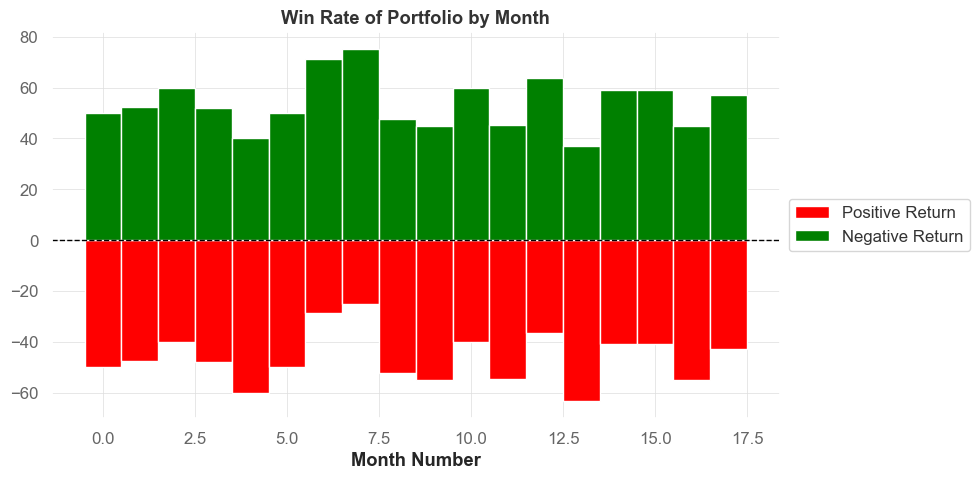

In [44]:
metrics_rl_plot_monthly = (
    metrics_test.groupby(pd.Grouper(key='date', freq='M'))
    .agg(positive_returns=('returns', lambda x: (x > 0).sum()),  # Count positive returns
         total_days =('returns', 'size'))  # Count total weeks
    .reset_index()
)
# Calculate the proportion of positive returns
metrics_rl_plot_monthly['proportion_positive'] = metrics_rl_plot_monthly['positive_returns'] / metrics_rl_plot_monthly['total_days']

# Rename columns for clarity
metrics_rl_plot_monthly.rename(columns={'date': 'month', 'proportion_positive': 'proportion_of_positive_returns'}, inplace=True)
metrics_rl_plot_monthly['month'] = metrics_rl_plot_monthly['month'].dt.strftime("%b %Y")
metrics_rl_plot_monthly['row_number'] = range(len(metrics_rl_plot_monthly))
metrics_rl_plot_monthly['proportion_of_positive_returns'] = metrics_rl_plot_monthly['proportion_of_positive_returns'] * 100
metrics_rl_plot_monthly['red'] = 100 - metrics_rl_plot_monthly['proportion_of_positive_returns']
metrics_rl_plot_monthly['green'] = metrics_rl_plot_monthly['proportion_of_positive_returns']
# plt.plot(metrics_rl_plot_monthly['row_number'], metrics_rl_plot_monthly["proportion_of_positive_returns"]*100, "b")
fig, ax = plt.subplots(figsize=(10, 5))
# metrics_rl_plot_monthly
# Plotting stacked bars
row_number = metrics_rl_plot_monthly['row_number']
bar_width=1
# Plot the red portion (below 50%)
ax.bar(row_number, -metrics_rl_plot_monthly['red'], 
       bar_width, label='Positive Return', color='red')

# Plot the green portion (above 50%)
ax.bar(row_number, metrics_rl_plot_monthly['green'], 
       bar_width, label='Negative Return', color='green')

# Add a reference line at y=0 (which corresponds to the 50% mark)
ax.axhline(0, color='black', linewidth=1, linestyle='--')

# Set axis labels and title
ax.set_xlabel("Month Number", fontweight='bold')
ax.set_title("Win Rate of Portfolio by Month", fontweight='bold')

# Remove y-axis labels and ticks (as they are not needed)
# ax.set_yticks([])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Show plot
plt.tight_layout()
plt.show()


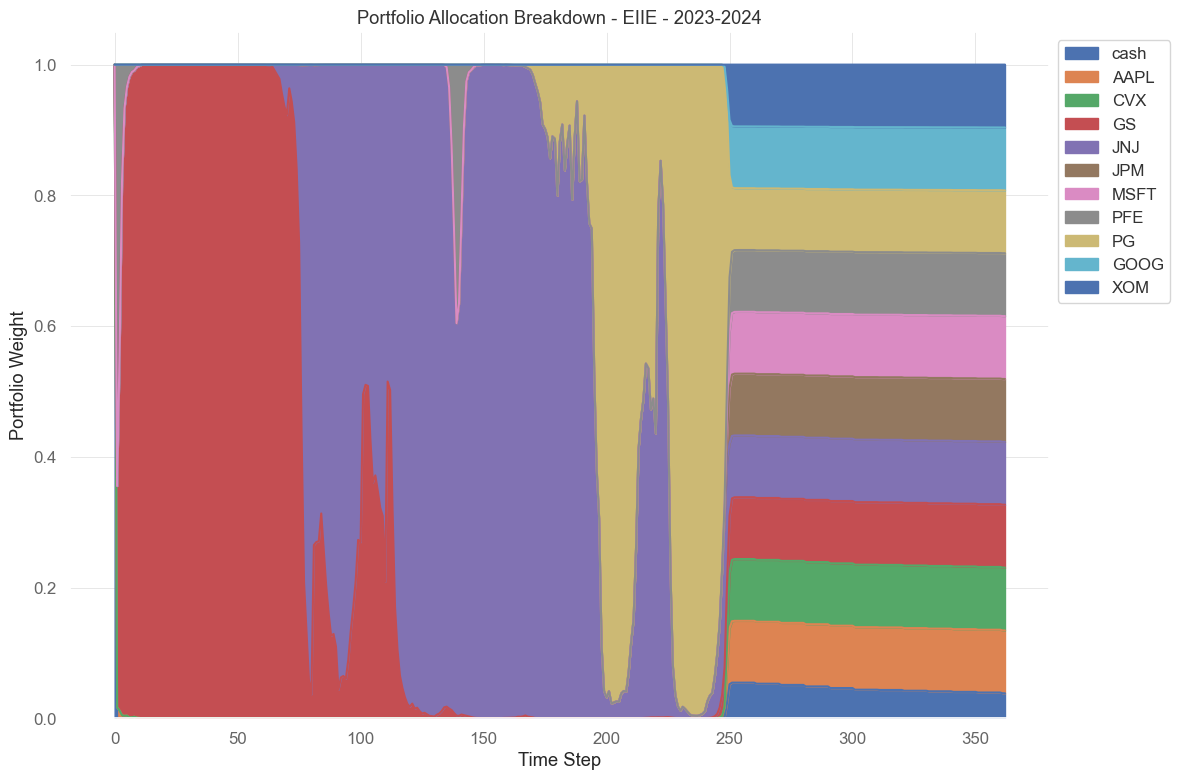

,TIME_WINDOW,K_SIZE,CONV_MID,CONV_FINAL,train_portfolio_value,train_drawdown,train_sharpe,train_cumulative,test_portfolio_value,test_drawdown,test_sharpe,test_cumulative,validation_portfolio_value,validation_drawdown,validation_sharpe,validation_cumulative
0,90,5,10,20,1673852.75,-0.270577,1.654936,16.738528,154338.328125,-0.140134,1.583425,1.543383,190805.65625,-0.184853,1.480229,1.908057
1,90,5,10,20,1673852.75,-0.270577,1.654936,16.738528,154338.328125,-0.140134,1.583425,1.543383,NaN,NaN,NaN,NaN
2,90,5,10,20,1673852.75,-0.270577,1.654936,16.738528,154338.328125,-0.140134,1.583425,1.543383,NaN,NaN,NaN,NaN
3,90,5,10,20,1673852.75,-0.270577,1.654936,16.738528,154338.328125,-0.140134,1.583425,1.543383,NaN,NaN,NaN,NaN


In [45]:
# Function to plot action memory
def plot_action_memory(actions, tickers, label):
    """Visualize portfolio allocation over time."""
    actions_df = pd.DataFrame(actions, columns=["cash"] + tickers)
    actions_df.plot(kind="area", figsize=(12, 8), title=f"Portfolio Allocation Breakdown - {label}")
    plt.ylabel("Portfolio Weight")
    plt.xlabel("Time Step")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Plot EIIE actions for the training period
# plot_action_memory(EIIE_results["train"]["actions"], TEST_SET, "EIIE - Train")

# Plot EIIE actions for test
plot_action_memory(EIIE_results["test"]["actions"], TEST_SET, "EIIE - 2023-2024")

# Similarly, plot UBAH actions for each period
# plot_action_memory(UBAH_results["train"]["actions"], TEST_SET, "UBAH - Train")
# plot_action_memory(UBAH_results["2021"]["actions"], TEST_SET, "UBAH - 2021")
# plot_action_memory(UBAH_results["2022"]["actions"], TEST_SET, "UBAH - 2022")
# plot_action_memory(UBAH_results["2023"]["actions"], TEST_SET, "UBAH - 2023")

temp_df = pd.DataFrame([{
        "TIME_WINDOW": TIME_WINDOW, "K_SIZE": K_SIZE, "CONV_MID": CONV_MID, "CONV_FINAL": CONV_FINAL,
        "train_portfolio_value": train_final_value, "train_drawdown": train_drawdown, "train_sharpe": train_sharpe, "train_cumulative": train_cumulative,
        "test_portfolio_value": portfolio_test_value, "test_drawdown": drawdown_test, "test_sharpe": sharpe_test, "test_cumulative": cumulative_test}]
)
results_df = pd.concat([results_df, temp_df], ignore_index=True)
    
results_df

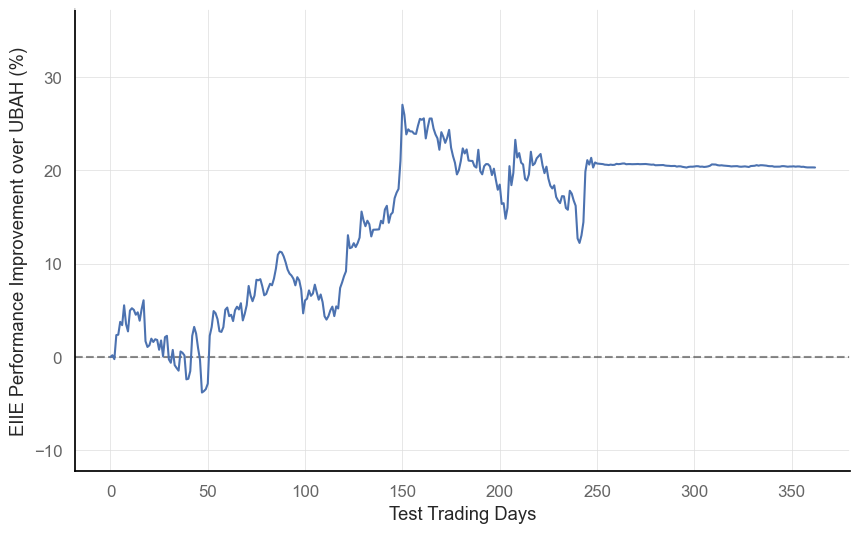

In [46]:
#diff =  EIIE_results["test"]["value"] - UBAH_results["test"]["value"]
normdiff = [(i -j)/j for i, j in zip(EIIE_results["test"]["value"], UBAH_results["test"]["value"])]
percentagediff = [i*100 for i in normdiff]
plt.axhspan(-10, 35, alpha=0)
#x axis line
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5) 
plt.annotate('Equivalent Performance of Models', (390, -0.025), textcoords="offset points", xytext=(0,5), ha='right', fontsize=14)
# plt.grid(False)

# Add solid lines for axes
plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')

#add labels
plt.xlabel("Test Trading Days")
plt.ylabel("EIIE Performance Improvement over UBAH (%)")
plt.plot(percentagediff)

